<a href="https://colab.research.google.com/github/EmineSener/Computer-Vision-With-Transformer/blob/main/Coursera_Cifar_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, re, time, json  # Import necessary libraries for file operations, regular expressions, timing, and JSON handling
import PIL.Image, PIL.ImageFont, PIL.ImageDraw  # Import PIL modules for image processing
import numpy as np  # Import numpy library for numerical operations
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x  # Check if using TensorFlow version 2.x (specific to Colab environment)
except Exception:
  pass
import tensorflow as tf  # Import TensorFlow library
from tensorflow.keras.applications.resnet50 import ResNet50  # Import ResNet50 model from Keras applications
from matplotlib import pyplot as plt  # Import pyplot module from matplotlib for plotting
import tensorflow_datasets as tfds  # Import TensorFlow Datasets library for accessing datasets

print("Tensorflow version " + tf.__version__)  # Print TensorFlow version

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.15.0


## Parameters

- Define the batch size
- Define the class (category) names

In [ ]:
BATCH_SIZE = 32  # Set the batch size to 32. Batch size determines the number of samples processed before the model is updated.
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help you to create some visualizations. (These will be used later)

In [ ]:
#@title Visualization Utilities[RUN ME]

# Matplotlib configuration
plt.rc('image', cmap='gray')  # Set colormap to grayscale for images
plt.rc('grid', linewidth=0)  # Set grid linewidth to 0 (no grid lines)
plt.rc('xtick', top=False, bottom=False, labelsize='large')  # Customize x-axis ticks
plt.rc('ytick', left=False, right=False, labelsize='large')  # Customize y-axis ticks
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')  # Customize axes appearance
plt.rc('text', color='a8151a')  # Set text color
plt.rc('figure', facecolor='F0F0F0')  # Set figure facecolor

# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# Utility function to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):
    n = 10  # Number of images to display

    # Choose random indexes to display
    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]  # Get corresponding images
    n_predictions = predictions[indexes]  # Get corresponding predictions
    n_predictions = n_predictions.reshape((n,))  # Reshape predictions to 1D array
    n_labels = labels[indexes]  # Get corresponding actual labels

    # Create a figure to display the images
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    # Plot the images
    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        class_index = n_predictions[i]
        plt.xlabel(classes[class_index])  # Set xlabel with predicted class name
        plt.xticks([])
        plt.yticks([])
        plt.imshow(n_digits[i])  # Display the image

# Utility function to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

# Comment: This part of the code defines utility functions for visualizing images, predictions, and training/validation curves.


## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. You will load the dataset from Keras.

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

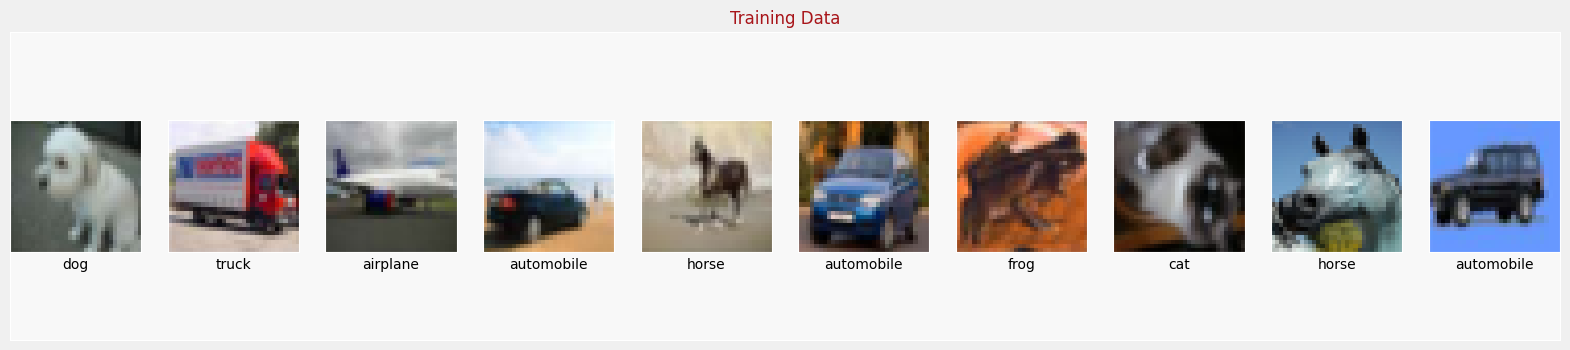

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

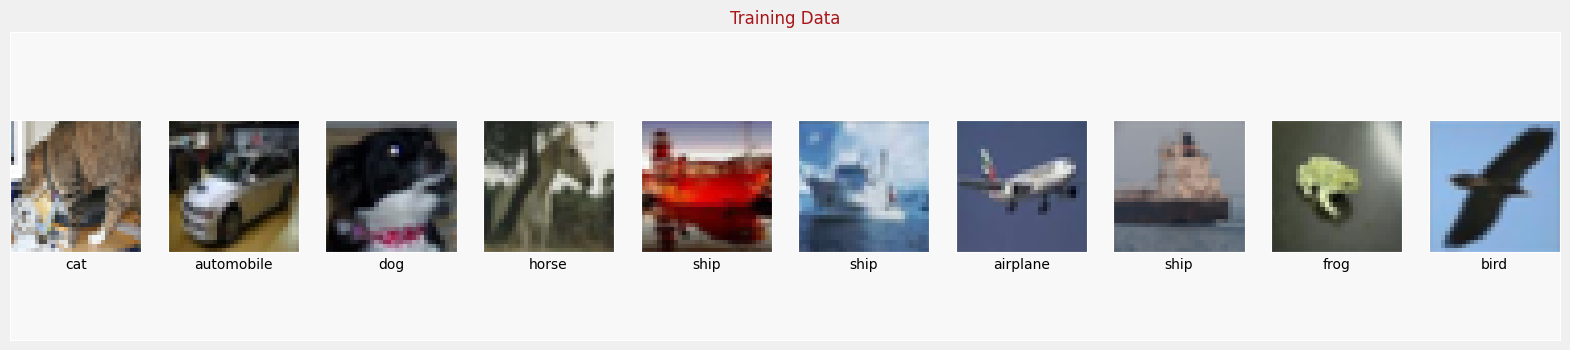

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [ ]:
validation_images[0].astype('float32').shape

(32, 32, 3)

### Preprocess Dataset
Here, you'll perform normalization on images in training and validation set.
- You'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [ ]:
# The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
def preprocess_image_input(input_images):
    input_images = input_images.astype('float32')  # Convert input images to float32 datatype
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)  # Preprocess input images using ResNet50's preprocess_input function
    return output_ims

In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network
You will be performing transfer learning on **ResNet50** available in Keras.
- You'll load pre-trained **imagenet weights** to the model.
- You'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):
    # Instantiate ResNet50 model without the top classifier, using ImageNet weights
    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),  # Specify input shape as 224x224x3
                                                              include_top=False,  # Exclude the top (classification) layer
                                                              weights='imagenet')(inputs)  # Use pre-trained ImageNet weights
    return feature_extractor


In [ ]:
'''
Defines final dense layers and subsequent softmax layer for classification.
ours new classifier
'''
def classifier(inputs):
    # Global average pooling layer reduces spatial dimensions to 1x1
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    # Flatten layer converts the input into a 1D array
    x = tf.keras.layers.Flatten()(x)
    # Dense layer with 1024 units and ReLU activation function
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    # Dense layer with 512 units and ReLU activation function
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    # Dense layer with 10 units and softmax activation function for classification
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [ ]:
'''
Since input image size is (32 x 32), first upsample the image by a factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):
    # Resize the image to (224 x 224) by using an upsampling layer with a (7x7) upsampling factor
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    # Perform feature extraction on the resized image
    resnet_feature_extractor = feature_extractor(resize)

    # Connect the output of the feature extraction to the classifier layers
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

In [ ]:
'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))  # Define input layer with shape (32, 32, 3)

    classification_output = final_model(inputs)  # Get the classification output from the final model
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)  # Define the model with input and output layers

    # Compile the model with Stochastic Gradient Descent (SGD) optimizer, Sparse Categorical Crossentropy loss function, and accuracy metric
    model.compile(optimizer='SGD',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

## Train the model

In [1]:
# this will take around 20 minutes to complete
EPOCHS = 2
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

NameError: name 'model' is not defined

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

In [ ]:
# Utility function to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

In [ ]:
plot_metrics("accuracy", "Accuracy")

### Visualize predictions
You can take a look at the predictions on the validation set.

In [ ]:
probabilities = model.predict(valid_X, batch_size=64)  # Perform predictions on validation data
probabilities = np.argmax(probabilities, axis=1)  # Get the index of the highest probability as the predicted label

# Display images along with their predicted labels
display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")
